## 7 - Linear mixed effects models
### Dealing with repeated measurements

This week we expand our modelling repertoire to deal with an important issue in psychology and behavioural science - what happens when you have repeated measurements in your data?

You might remember the *assumption of independent errors*. This subtle assumption means, simply, that a standard GLM expects each row of the data to be **unrelated** to the others. If this is the case, then each residual is also independent. 

But very often in psychological datasets, we have **repeated measurements**, where participants are measured multiple times, or give us many responses on different variables. If we ignore this, we will end up biasing our coefficients, and by extension, altering our predictions and how sure we are about them.

**Linear mixed effects models** allow us to deal with these kinds of data, and allow us to build complex models that allow us to investigate individual differences in a clear fashion when participants give us a lot of repeated data. How they do it can be confusing, but we can work through code-based examples to see how.

We need to import all our usual packages to investigate these models:

In [1]:
# Import what we need
import pandas as pd # dataframes
import seaborn as sns # plots
import statsmodels.formula.api as smf # Models
import marginaleffects as me # marginal effects
import numpy as np # numpy for some functions
import statsmodels.tools.eval_measures as measures

# Set the style for plots
sns.set_style('whitegrid')
sns.set_context('talk')

### Professors and repeated measurements
In an earlier example we investigated the effect of instructor attractiveness on teaching evaluations. At the time, we noted that this dataset actually violated the assumption of independent errors, but carried on in the interests of learning!

Now, we will use an appropriate model to examine this relationship in more detail, and see what happens if we actually meet this assumption - and show how to use them in practice. First lets read in the data and fit a standard GLM to it, which we know is incorrect:

In [2]:
# Read in data
profs = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/AER/TeachingRatings.csv')

# Display data
display(profs.head(), profs.tail())

# Fit a GLM predicting evaluation from sex
glm = smf.ols('eval ~ scale(beauty)', data=profs).fit()
glm.summary(slim=True)

,rownames,minority,age,gender,credits,beauty,eval,division,native,tenure,students,allstudents,prof
0,1,yes,36,female,more,0.289916,4.3,upper,yes,yes,24,43,1
1,2,no,59,male,more,-0.737732,4.5,upper,yes,yes,17,20,2
2,3,no,51,male,more,-0.571984,3.7,upper,yes,yes,55,55,3
3,4,no,40,female,more,-0.677963,4.3,upper,yes,yes,40,46,4
4,5,no,31,female,more,1.509794,4.4,upper,yes,yes,42,48,5


,rownames,minority,age,gender,credits,beauty,eval,division,native,tenure,students,allstudents,prof
458,459,no,32,male,more,1.231394,3.2,lower,yes,yes,9,21,93
459,460,no,32,male,more,1.231394,4.3,upper,yes,yes,52,86,93
460,461,yes,42,female,more,0.420400,3.3,upper,no,yes,52,67,94
461,462,yes,42,female,more,0.420400,3.2,upper,no,yes,54,66,94
462,463,yes,42,female,single,0.420400,4.1,lower,no,yes,28,35,94


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   eval   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
No. Observations:                 463   F-statistic:                     17.08
Covariance Type:            nonrobust   Prob (F-statistic):           4.25e-05
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.9983      0.025    157.727      0.000       3.948       4.048
scale(beauty)     0.1048      0.025      4.133      0.000       0.055       0.155
=================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As before, we see significant effects of both gender and beauty. But if we look at the data display we can see the `prof` variable, which indicates which professor gave the class and is being evaluated, has multiple rows per professor - so we know our GLM is in trouble! 

We can correct this by using the `mixedlm` command. We can do an awful lot of stuff with this command, fitting complex models with repeated measures data, but first lets see how to make a model aware that there are repeated measures:

In [3]:
# Using a mixed model
mix = smf.mixedlm('eval ~ scale(beauty)', # formula is the same
                  groups='prof', # groups is the variable that 'keeps track' of which row belongs to which professor - or whatever group!
                  data=profs).fit()

mix.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: eval     
No. Observations: 463     Method:             REML     
No. Groups:       94      Scale:              0.1705   
Min. group size:  1       Log-Likelihood:     -321.9997
Max. group size:  13      Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     3.929    0.045 88.145 0.000  3.841  4.016
scale(beauty) 0.091    0.042  2.147 0.032  0.008  0.174
prof Var      0.139    0.075                           
=======================================================

"""

We can note several things from this output:
1. `No. Groups` - the model has identified there are 94 unique professors in the data.
2. `Min. group size` - this means there is at least one professor who had just one rating/course that was evaluated.
3. `Max. group size` - this means there is at least one professor who had 13 ratings/courses that were evaluated.
4. `Mean group size` - on average, each professor was rated 4.9 times.
5. `Scale` - this is the *variance of the residuals*. 
6. `prof Var` - there is now a new output! This interesting line tells us how much variation in our evaluation ratings is due to differences amongst professors - neat!

Notice however that the coefficients are slightly different to the GLM - the mixed effects model has slightly different coefficients and wider intervals, and the *p*-values are different. This is only a simple example but the differences can be much larger in practice!

Is it worth all this extra stress though? If we examine the RMSE of both models we'll see why it is...

In [4]:
# RMSE for both models
glm_rmse = measures.rmse(glm.model.endog, glm.fittedvalues)
mix_rmse = measures.rmse(mix.model.endog, mix.fittedvalues)
display(f'GLM RMSE: {glm_rmse:.2f}', f'Mixed Model RMSE: {mix_rmse:.2f}')

'GLM RMSE: 0.54'

'Mixed Model RMSE: 0.38'

### Random effects - how mixed models work
How do these models work? What do they do that allows us to incorporate the repeated measures? 

They incorporate a clever statistical trick known as 'random effects', and these come in two types - a 'random intercept', and a 'random slope'. 

#### Random intercepts
What is a random intercept? Quite simply, it is an *intercept estimated for each specific group in the data*. In our case, each professor gets their own intercept. While there is indeed a *global* intercept, each professor has their own, and they represent - compared to the global intercept - whether the professor is above or below on their teaching evaluations. Lets take a look at them:

,prof
1,0.028885
2,-0.219941
3,-0.255526
4,0.140606
5,0.204728


<Axes: ylabel='Count'>

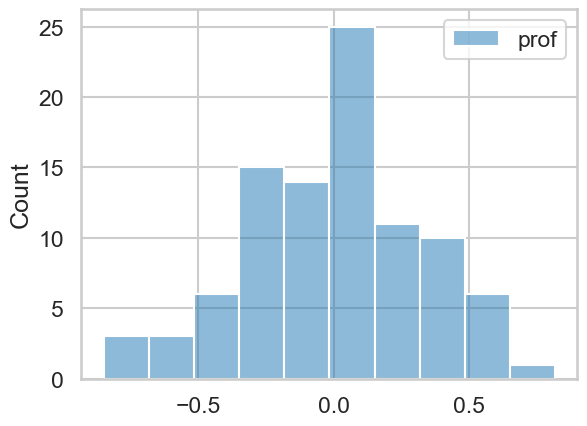

In [5]:
# Retrieve the intercepts - they are stored as a dictionary in the `.random_effects` attribute of the model. We can convert them into a DataFrame like so
professor_effects = pd.DataFrame.from_dict(mix.random_effects, orient='index')
display(professor_effects.head())

# histogram of random effects
sns.histplot(professor_effects)

You can see they are centred around zero, because they are 'offset' from the global intercept. If we wanted to, we could add the global intercept to these, and obtain each professors actual intercept - same information, just represented differently.

The key thing to retain here is that the model is 'figuring out' multiple regression lines - in fact, one regression line per professor. They all have the same slope, but they all start from a different intercept point. Here's a plot to visualise exactly what's going on:

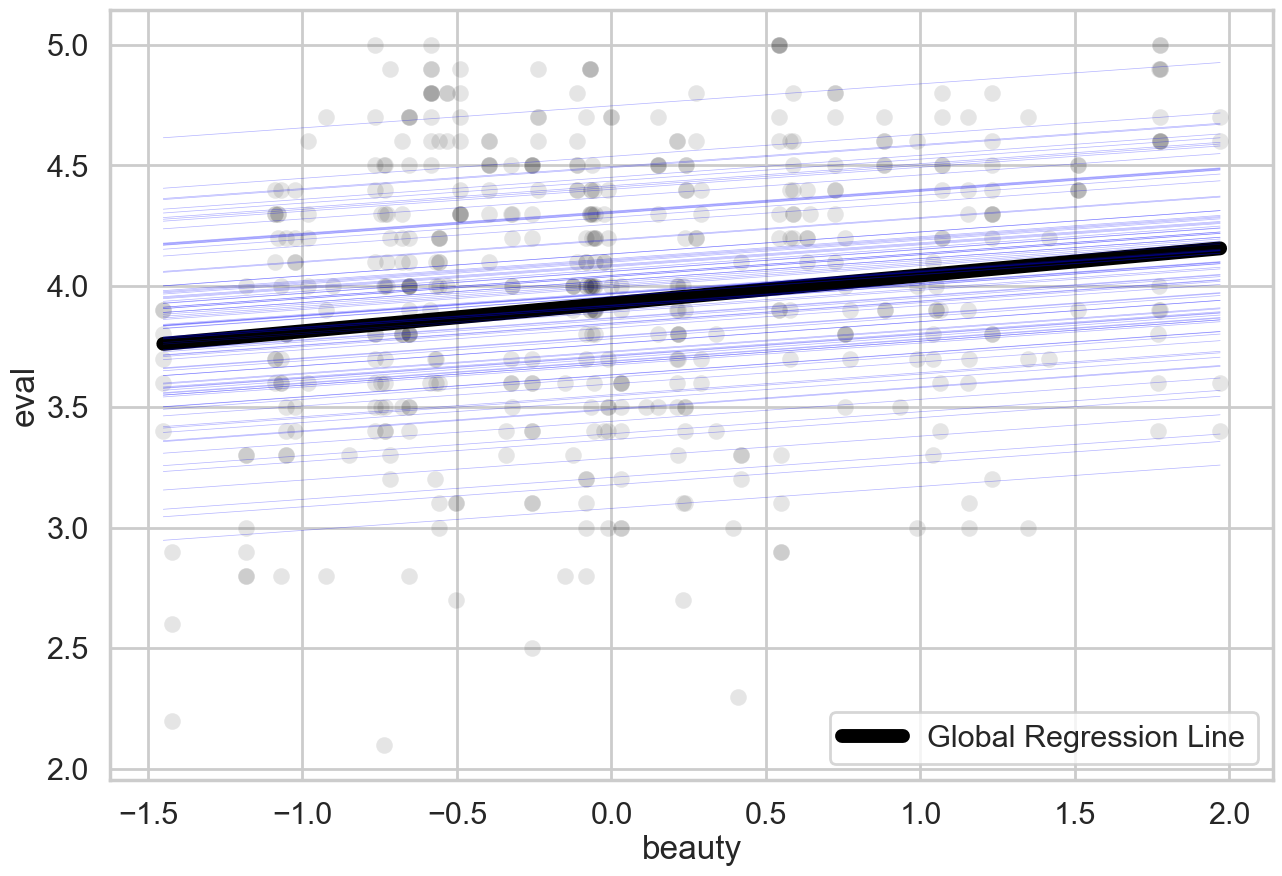

In [6]:
# Plot all random effects and data
import matplotlib.pyplot as plt
with sns.plotting_context('poster'):

    # Canvas
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    # Data scatter
    sns.scatterplot(data=profs, x='beauty', y='eval', color='black', alpha=.1, ax=ax)

    # Add the global line of best fit, which we obtain from predictions
    preds = me.predictions(mix)
    sns.lineplot(data=preds, x='beauty', y='estimate', color='black', linewidth=10, label='Global Regression Line')

    # A bit of trickery to get each professors line!
    for intercept in professor_effects.itertuples():
        ax.plot( 
            (x := np.linspace(profs['beauty'].min(), profs['beauty'].max(), 100)),
            (mix.params['Intercept'] + intercept.prof) + mix.params['scale(beauty)'] * x, 
            linewidth=.5, alpha=.3, color='blue', label='An individual professor'
        )

*This* is how the model deals with the assumption. It fits separate regression lines for each professor, who all have the same slope for beauty but have different intercepts. 

The mathematics behind these models are very elegant, but we need not concern ourselves. We can think of it in two exchangeable ways:
- The model figures out a global intercept and then tries its best to provide a best-fitting offset for each person, or
- The model gives everyone a single intercept and then averages them together as best it can to get the global intercept.


#### Random intercepts AND random slopes
While a random intercept is sufficient for us to fix the assumption of independent errors, there is far more to linear mixed models than just this. In the following example we'll see how we can use their flexibility to map individual differences with intercepts and slopes. This is where things can get tricky, so we will take it slow. 

We are going to examine data from a sleep-deprivation study, that illustrates how sleep restriction (~ 3 hours a night) affects reaction times on a task. Each participants reaction time was measured at baseline (day zero) before they started 9 days of sleep restriction. First, let us read in this data, and take a look at the structure:

In [7]:
# Read in sleep data and look at structure
sleep = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/lme4/sleepstudy.csv')

# Show top 15
sleep.head(15)

,rownames,Reaction,Days,Subject
0,1,249.5600,0,308
1,2,258.7047,1,308
2,3,250.8006,2,308
3,4,321.4398,3,308
4,5,356.8519,4,308
5,6,414.6901,5,308
6,7,382.2038,6,308
7,8,290.1486,7,308
8,9,430.5853,8,308
9,10,466.3535,9,308


Each participant thus provides about 11 days worth of reaction time data. If we were to analyse this with a GLM, our inferences and predictions would be incorrect, but a linear mixed model will be of great use. We can in fact plot the variation in reaction time, across days, for each participant, to give us a sense of what we're trying to do:

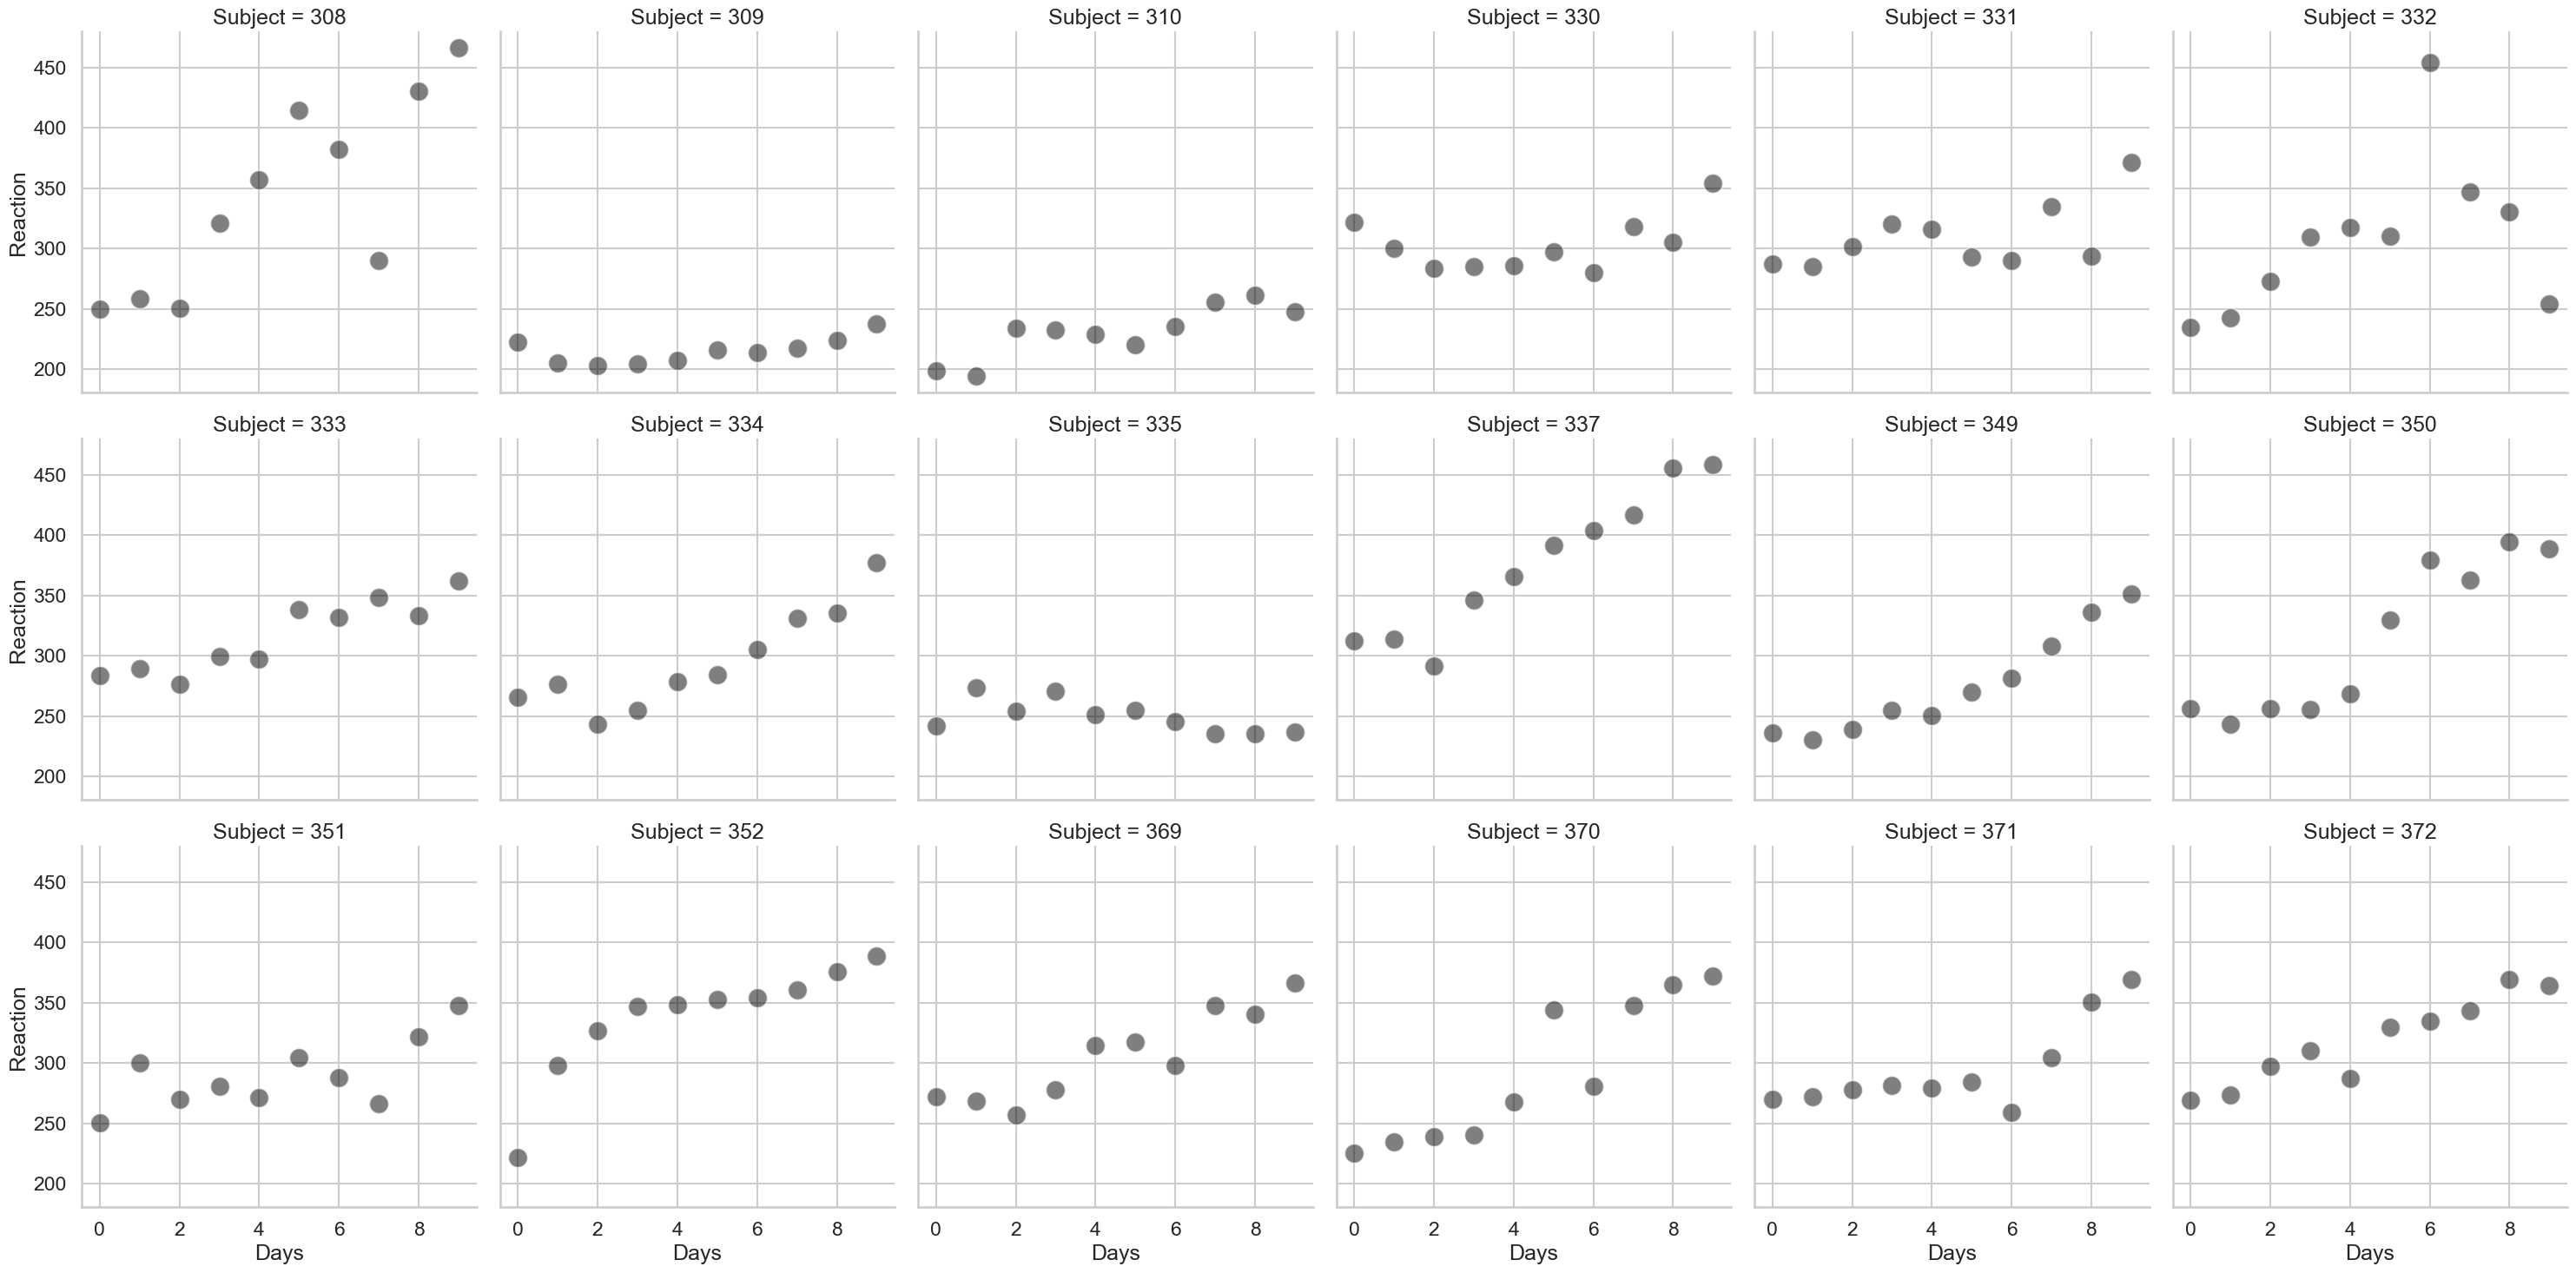

In [8]:
# Plot all data
fig = sns.relplot(data=sleep,
                  x='Days', y='Reaction', 
                  col_wrap=6,
                  s=250, color='black',
                  alpha=.5,
                  col='Subject')

As can be seen, there's a lot of variability here. Lets first use the (incorrect) GLM to predict how reaction time changes with increasing time spent with poor sleep, and see how it looks:

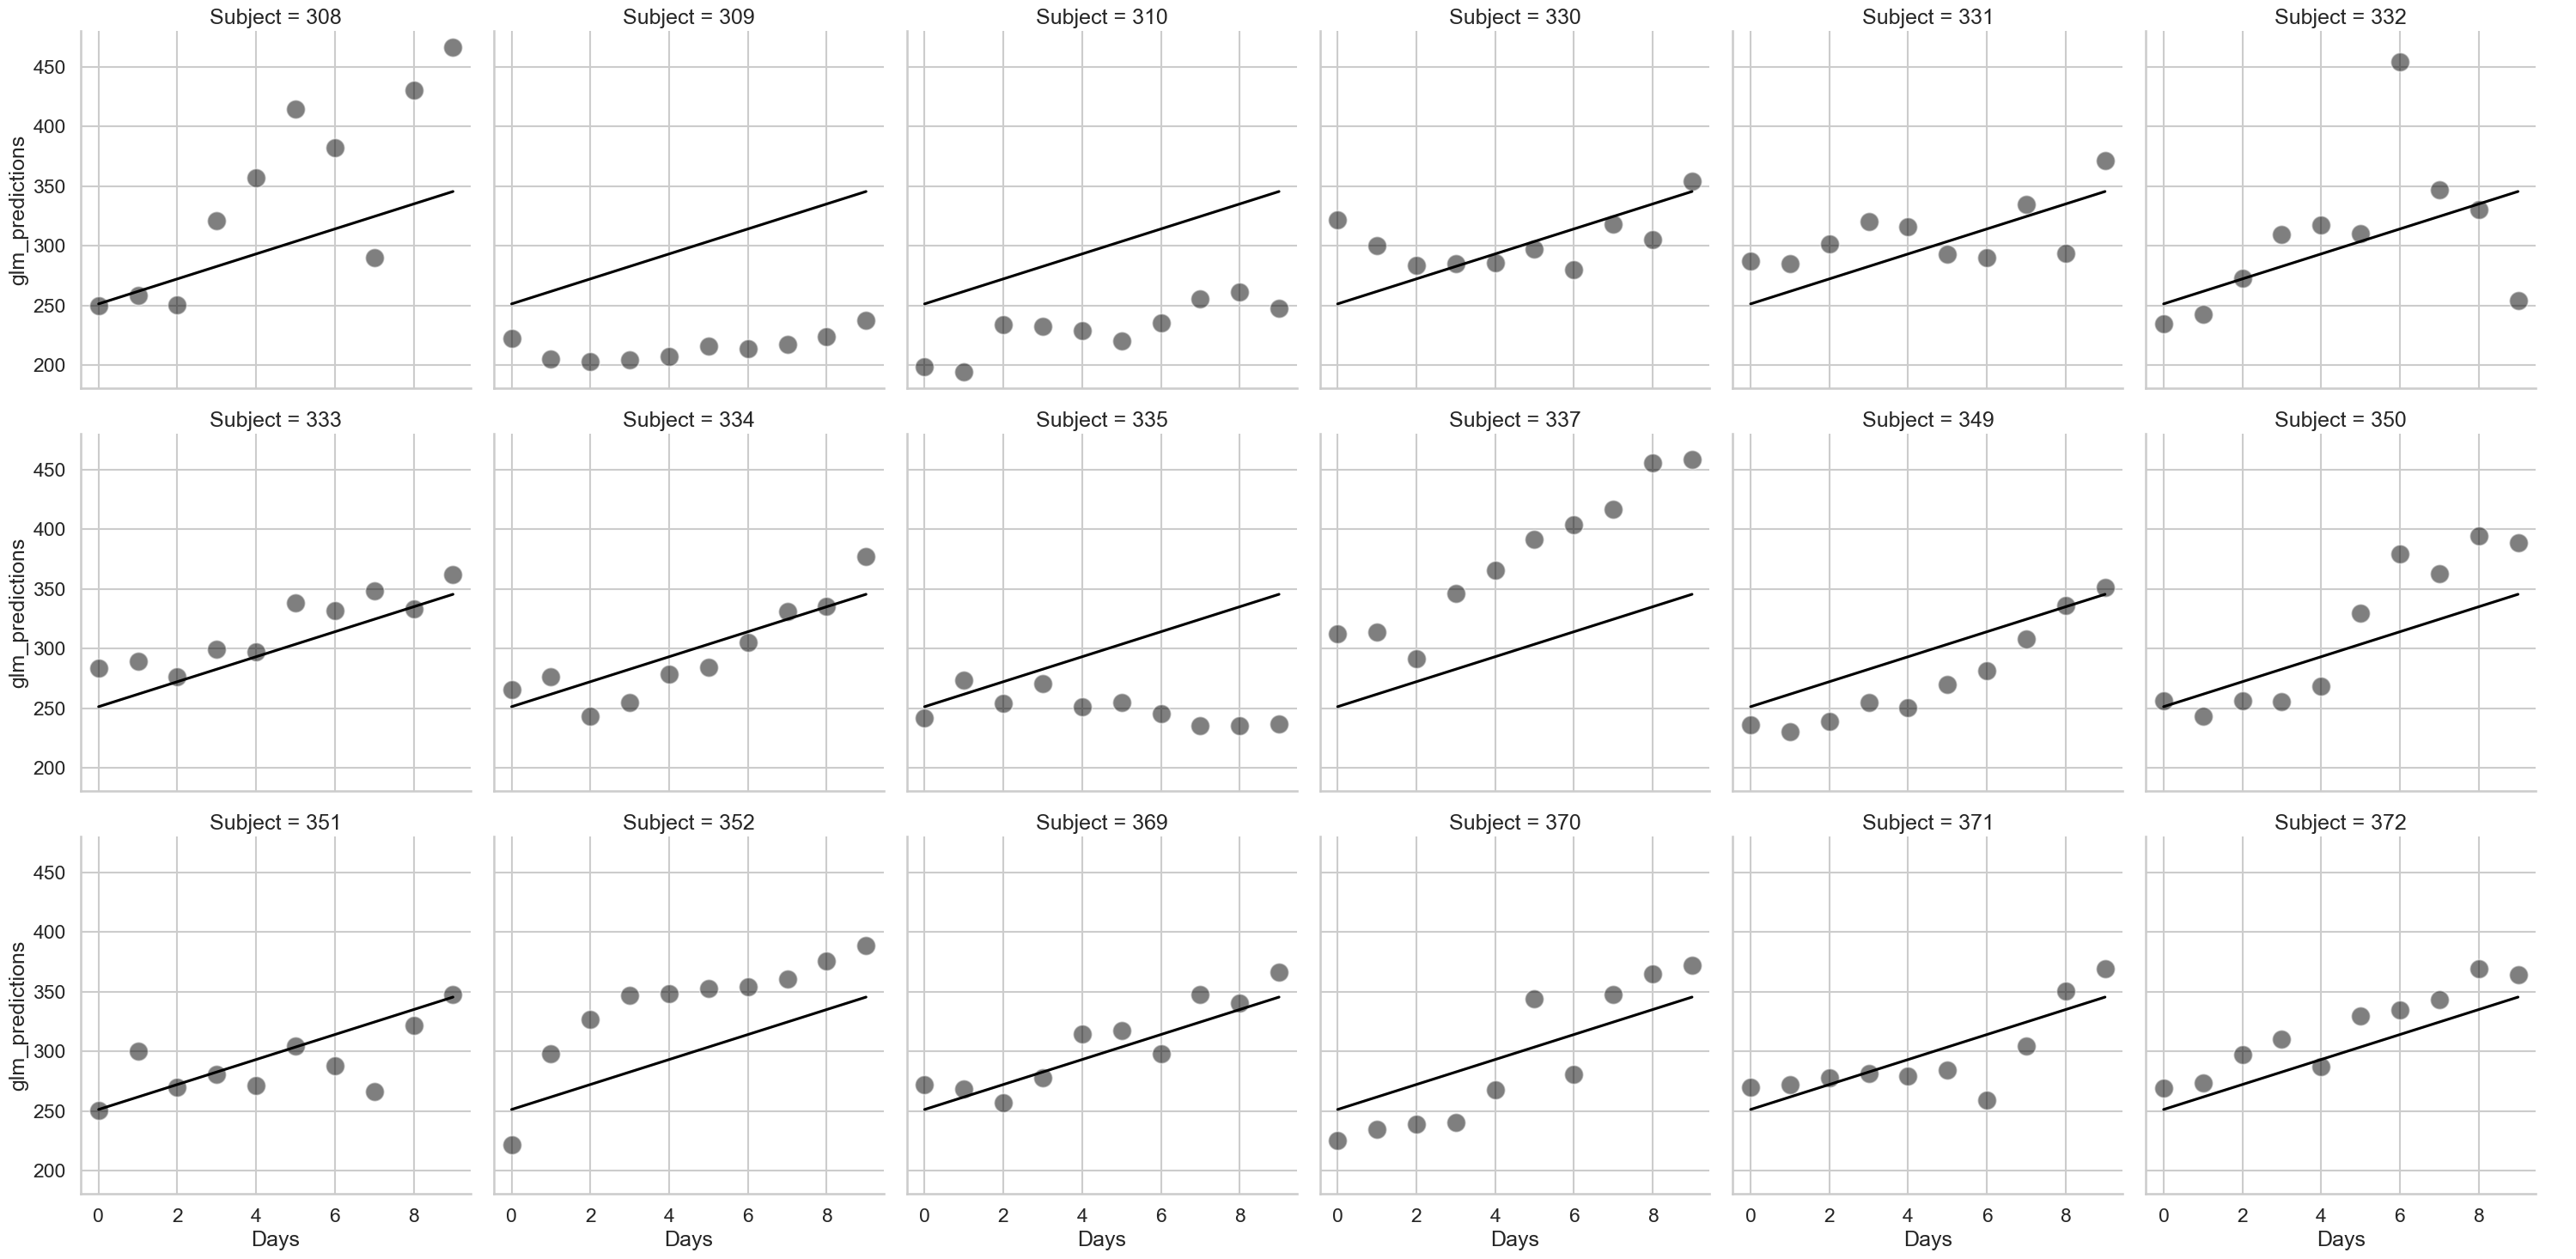

In [9]:
# An incorrect GLM
glm = smf.ols('Reaction ~ Days', data=sleep).fit()

# Get predictions, adding them to the dataset
sleep['glm_predictions'] = glm.fittedvalues# an easy quick way of obtaining just the predictions, no extra bits

# Add the predictions to the plot
fig2 = sns.relplot(data=sleep,
                   x='Days', y='Reaction', 
                   col_wrap=6,
                   s=250, color='black',
                   alpha=.5,
                   col='Subject').map(sns.lineplot, 'Days', 'glm_predictions', color='black').add_legend()

In [10]:
# And take a look at the GLM output
glm.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Reaction   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.282
No. Observations:                 180   F-statistic:                     71.46
Covariance Type:            nonrobust   Prob (F-statistic):           9.89e-15
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    251.4051      6.610     38.033      0.000     238.361     264.449
Days          10.4673      1.238      8.454      0.000       8.024      12.911
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As can be seen above, *the line is exactly the same for each person*. The GLM is blind to the fact each person has different data, and so we should not trust the results.

We can add a random intercept to this data as we did for the professor dataset, by telling the `mixedlm` command the name of the "group" variable - that is, the `Subject` column. How does that look?

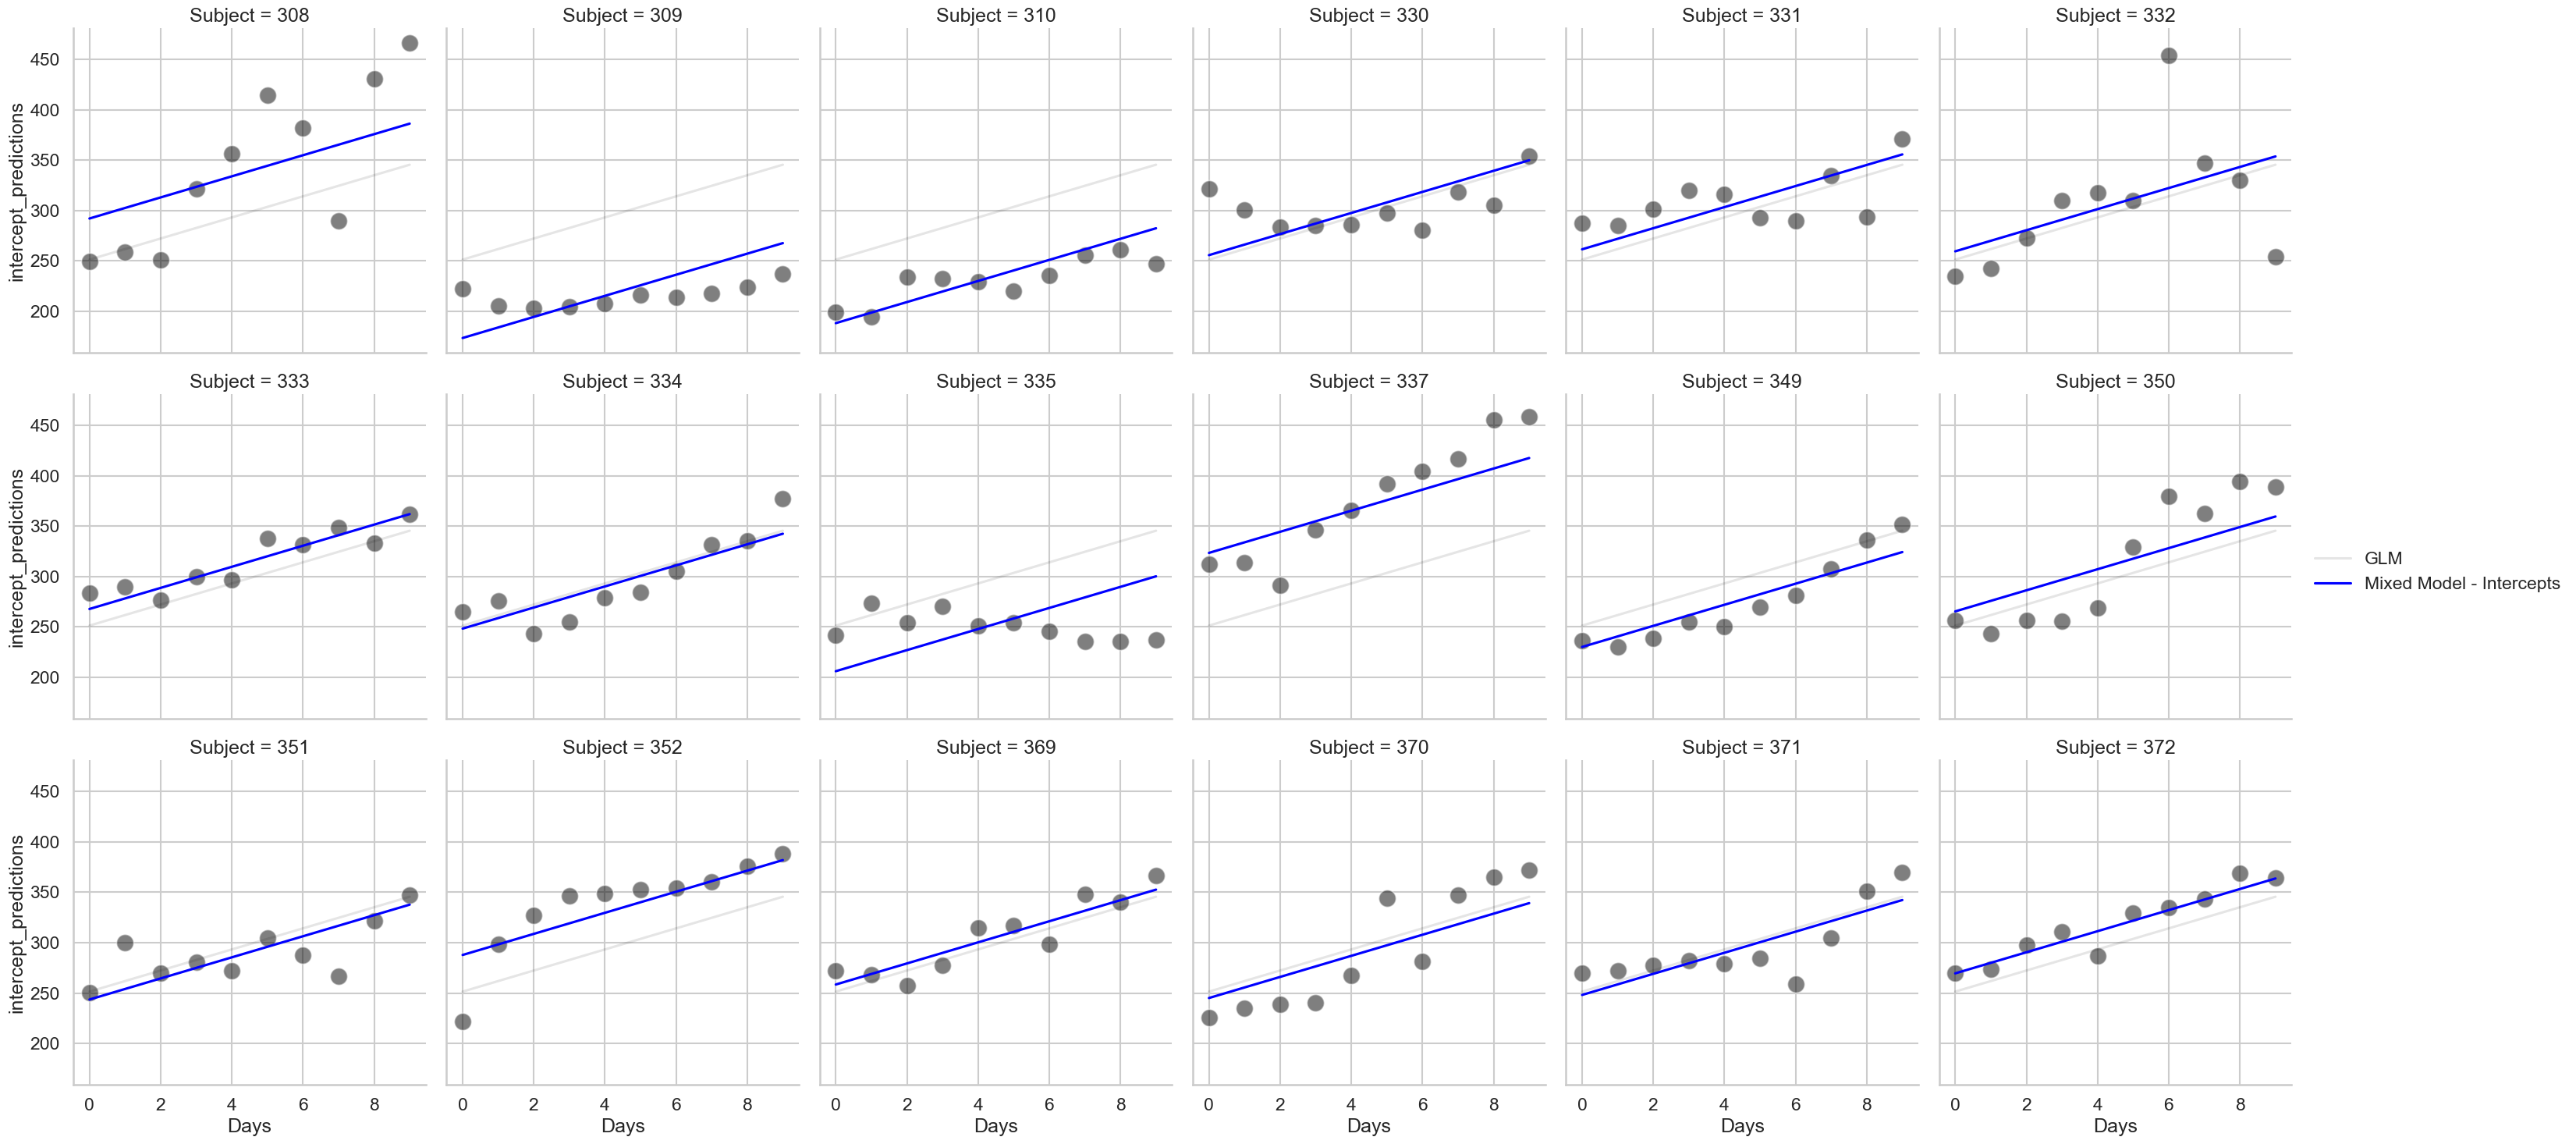

In [11]:
# Fit a mixed model with a random intercept
intercept = smf.mixedlm('Reaction ~ Days', 
                        groups='Subject',
                        data=sleep).fit()

# Get the predictions
sleep['intercept_predictions'] = intercept.fittedvalues

# Add the predictions to the plot
fig2 = (sns.relplot(data=sleep,
                    x='Days', y='Reaction', 
                    col_wrap=6,
                    s=250, color='black',
                    alpha=.5,
                    col='Subject')
         .map(sns.lineplot, 'Days', 'glm_predictions', color='black', alpha=.1, label='GLM')
         .map(sns.lineplot, 'Days', 'intercept_predictions', color='blue', label='Mixed Model - Intercepts')
         .add_legend()
        )

In [12]:
# And take a look at the model summary
intercept.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM  Dependent Variable:  Reaction 
No. Observations:  180      Method:              REML     
No. Groups:        18       Scale:               960.4568 
Min. group size:   10       Log-Likelihood:      -893.2325
Max. group size:   10       Converged:           Yes      
Mean group size:   10.0                                   
----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    251.405    9.747 25.794 0.000 232.302 270.508
Days          10.467    0.804 13.015 0.000   8.891  12.044
Subject Var 1378.176   17.156                             
==========================================================

"""

Notice how the intercepts in the graph alter, but not the slopes. Participant 369 has little difference for example - but the varying intercepts allow better predictions for Participant 337 and 352. The model is now 'aware' of the differences and has incorporated them. Also notice that the results here are relatively unchanged! The coefficients are broadly similar and are always significant - but the *quality* of the mixed model predictions are clearly more accurate!

### The random slope
Now for the crowning glory - while we can include random intercepts for all our participants, we can also include a *random slope*. This means we can let the slope of Day vary for each person (or indeed, any other predictor). This requires us to modify our `mixedlm` command a little. We now include the `re_formula` keyword, and pass it the name of the column we'd like to have the slopes for, as shown below. Note that this also includes the random intercepts - only in very rare circumstances would you exclude intercepts and fit only random slopes.

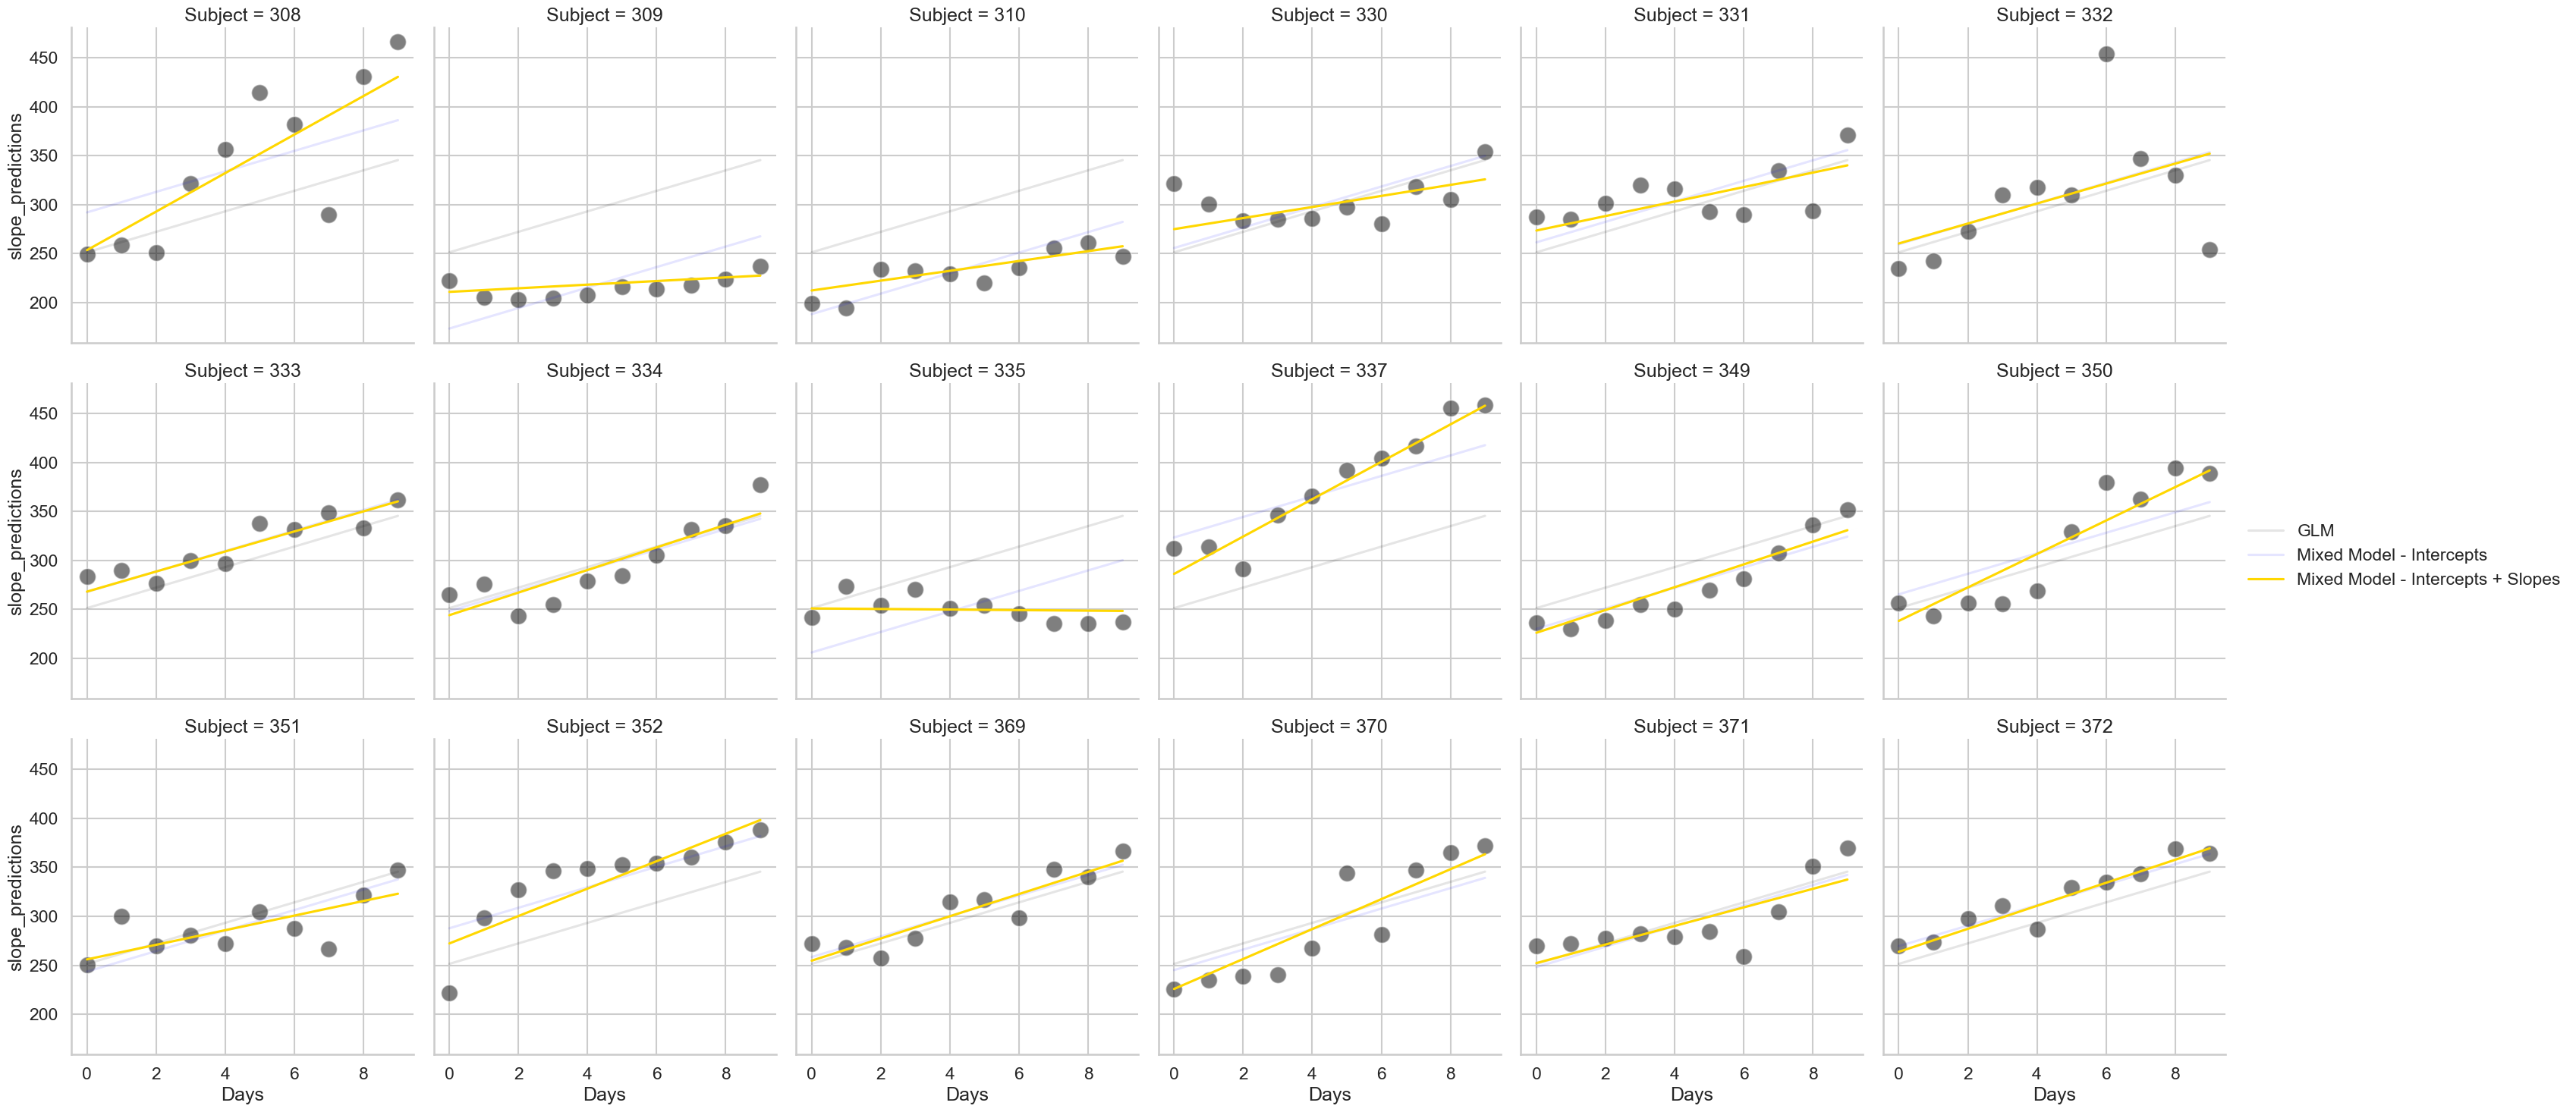

In [13]:
# Our final model
slopes = smf.mixedlm('Reaction ~ Days', 
                     groups='Subject',
                     re_formula='Days', # Where the magic happens
                     data=sleep).fit()

# Extract predictions
sleep['slope_predictions'] = slopes.fittedvalues

# And show
fig3 = (sns.relplot(data=sleep,
                    x='Days', y='Reaction', 
                    col_wrap=6,
                    s=250, color='black',
                    alpha=.5,
                    col='Subject')
        .map(sns.lineplot, 'Days', 'glm_predictions', color='black', alpha=.1, label='GLM')
        .map(sns.lineplot, 'Days', 'intercept_predictions', color='blue', alpha=.1, label='Mixed Model - Intercepts')
        .map(sns.lineplot, 'Days', 'slope_predictions', color='gold', label='Mixed Model - Intercepts + Slopes')
        .add_legend()
        )

In [14]:
# Check the output
slopes.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM    Dependent Variable:    Reaction 
No. Observations:    180        Method:                REML     
No. Groups:          18         Scale:                 654.9405 
Min. group size:     10         Log-Likelihood:        -871.8141
Max. group size:     10         Converged:             Yes      
Mean group size:     10.0                                       
----------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          251.405    6.825 36.838 0.000 238.029 264.781
Days                10.467    1.546  6.771 0.000   7.438  13.497
Subject Var        612.096   11.881                             
Subject x Days Cov   9.605    1.821                             
Days Var            35.072    0.610                             
================================================================

"""

The random slopes and intercepts together improve the predictions overall, correcting many of errors that the random intercepts miss. Consider participants 308 and 309 - while the blue line does its best to fit their data, only by altering the slope can we properly account for their reaction time increases. Notice again the output of this model is, for all intents and purposes, the same as in the GLM! The coefficients are still signifcant and similar in size. Does this mean that model is just as good? No! Model structure is far more important than *p*-values. The RMSE of the models is revealing:

In [15]:
# RMSE
display(
    'GLM RMSE: ', measures.rmse(glm.model.endog, glm.fittedvalues),
    'Mixed Model Intercepts Only RMSE: ', measures.rmse(intercept.model.endog, intercept.fittedvalues),
    'Mixed Model Intercepts + Slopes RMSE: ', measures.rmse(slopes.model.endog, slopes.fittedvalues)
)

'GLM RMSE: '

47.448897509757494

'Mixed Model Intercepts Only RMSE: '

29.41062417621592

'Mixed Model Intercepts + Slopes RMSE: '

23.43805168478719

Note also the extra information present in the output of the model above. The `Subject Var` and `Days Var` rows tell us how much variance people alone contribute to the overall reaction time variation, and how much the variation between people there is in how they change over each day, respectively. One is far higher than the other - this suggests that people are more variable in their baseline reaction time than the effect of poor sleep is on changing that. It's also possible to do very advanced analyses such as correlating the random effects - that is, we can obtain each participants random intercept and slope, and correlate them, like so:

In [16]:
# Obtain random effects in a dataframe
ranefs = pd.DataFrame.from_dict(slopes.random_effects, orient='index')
display(ranefs.head(7),
        ranefs.corr())

,Subject,Days
308,2.258584,9.198969
309,-40.398695,-8.619686
310,-38.960356,-5.448864
330,23.690554,-4.814339
331,22.260257,-3.069902
332,9.039549,-0.272174
333,16.840475,-0.223631


,Subject,Days
Subject,1.000000,0.263547
Days,0.263547,1.000000


<Axes: xlabel='Subject', ylabel='Days'>

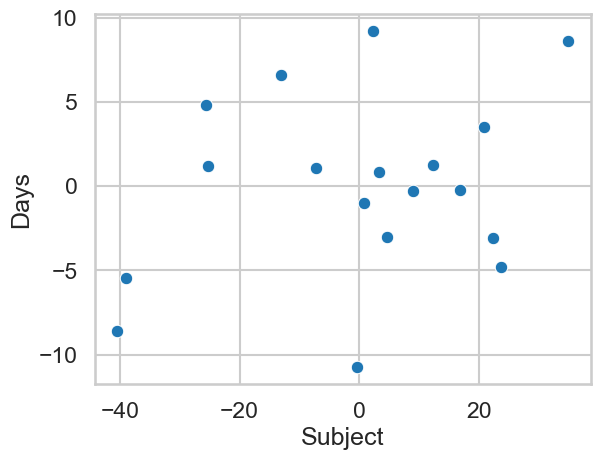

In [17]:
sns.scatterplot(x='Subject', y='Days', data=ranefs)

This suggest those with higher starting baselines (i.e., are slower to start with) show bigger increases in their reaction times with more time spent sleep deprived. 

### Building complexity with several random intercepts and random slopes
#### Using linear mixed models to identify individual differences
We turn now to a more complex example and push the capabilities of `statsmodels`. About ten years ago I was researching the effects of cosmetics on attractiveness as part of a collaboration with industry. One of the things our partners were interested in was how cosmetics impacted models differently - e.g., do some people get a bigger benefit from makeup than others, and how does that depend on their initial level of attractiveness? e.g. one might imagine more attractive models gain 'less' from cosmetics than do less attractive models. We didn't realise it at the time, but a linear mixed model would allow us to answer this question easily (in fact, it was not so easy to fit these models ten years ago!). The original paper is [here](https://alexjonesphd.github.io/assets/papers/2016/jones_kramer_2016.pdf).

To test this, we had a set of participants rate around 45 models for attractiveness, photographed with and without cosmetics. Our model is thus very simple, actually much like a t-test - `ratings ~ cosmetics` - how much does attractiveness change with makeup?

However, there are many sources of variability we didn't properly control for in this data. 
 - The first is the variability from *participants*, who will vary in how much they like the models. In fact we simply removed this variability by averaging - a terrible decision in hindsight. We can incorporate this as a random intercept for participants.
 - The second is the baseline level of attractiveness of each model. That is, how much more or less attractive than the average is each model? This can be incorporated as a random intercept for models - notice now we have **two** random intercepts!
 - The third is the effect of cosmetics on each model. That is, how much does the attractiveness of each model change with an application of cosmetics? In our initial analysis we addressed this in a very roundabout, indirect way. But with mixed models, this is simply incorporated as a random slope for cosmetics *for each model*.

Let's see if our conclusions hold when we use a proper model. To do this will involve some extra steps to coerce the model to fit. First, lets read in the data and take a look at it:

In [18]:
# Read in data
cosmetics = pd.read_csv('https://raw.githubusercontent.com/alexjonesphd/py4psy2024/refs/heads/main/jones_kramer_2015.csv')

# Show top 10 rows
display(cosmetics.head())

,pid,model_id,cosmetics,rating,cosmetics_code
0,44,1,without,2,0
1,44,2,with,5,1
2,44,3,without,5,0
3,44,4,without,3,0
4,44,5,without,3,0


The `pid` column represents the participant, `model_id` is the model identifier, the `cosmetics` and `cosmetics_code` columns show whether the instance was presented with/without makeup, and `rating` is the attractiveness rating assigned by that participant, to that model, in that makeup condition. We can visualise the overall pattern:

<Axes: xlabel='cosmetics', ylabel='rating'>

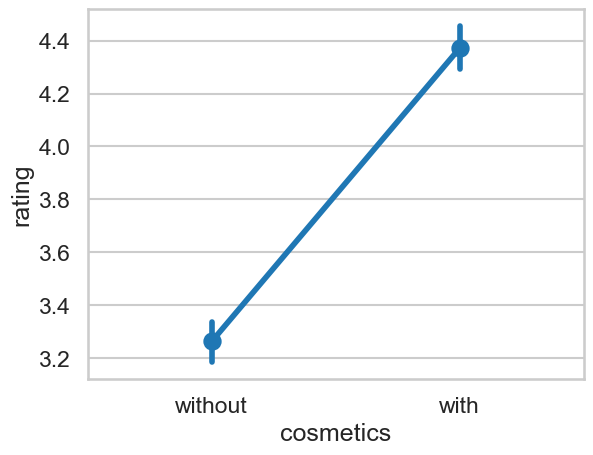

In [19]:
# Show overall
sns.pointplot(data=cosmetics, x='cosmetics', y='rating')

But this ignores the variability in the dataset from models and participants. Lets see how we can fit the structured model. 

To do this we must use an approach called **variance components**, which allows us to directly tell the model which ratings belong to which source (e.g., model, participant). The first step is to create a new variable that is the same number for everyone, that is, our grouping variable is the same for all data - we then can partition it up. This is easy:

In [20]:
# Create a variable with a single number for everyone
cosmetics['grouping'] = 1

# Show
display(cosmetics.head(), cosmetics.tail())

,pid,model_id,cosmetics,rating,cosmetics_code,grouping
0,44,1,without,2,0,1
1,44,2,with,5,1,1
2,44,3,without,5,0,1
3,44,4,without,3,0,1
4,44,5,without,3,0,1


,pid,model_id,cosmetics,rating,cosmetics_code,grouping
2998,30,29,without,3,0,1
2999,30,30,with,4,1,1
3000,30,31,with,5,1,1
3001,30,32,without,4,0,1
3002,30,33,with,5,1,1


Literally every row now has a '1' in it. That's our grouping variable. Next, we have to use some curious syntax to specify our random effects. 

We do this via a dictionary, and we give each source of variability a name. Then we use different expressions to indicate a random intercept or slope. 

- A random intercept would look like this: `0 + C(variable_name)` - we add a 'C' around the name to force Python to recognise it as a categorical variable. 
- A random slope would look like this: `0 + C(variable_name):predictor_name`. This is like saying 'there needs to be a random slope of `predictor_name` for each individual in the `variable_name` group'.

We want to have a random intercept for participants and models, and a random slope of cosmetics for each model, so:

In [21]:
# random effects
re = {'pid': '0 + C(pid)', 
      'model_id': '0 + C(model_id)',
      'cosmetics_model': '0 + C(model_id):cosmetics_code'} 

Then we specify them in our model (as well as our fixed grouping factor) like so:

In [22]:
# Fit our fancy model
cosmetics_model = smf.mixedlm('rating ~ cosmetics_code',
                              groups='grouping', # the constant grouping number
                              vc_formula=re, # the dictionary of vc
                              data=cosmetics).fit()

# Show the results
cosmetics_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  rating    
No. Observations:    3003     Method:              REML      
No. Groups:          1        Scale:               1.5169    
Min. group size:     3003     Log-Likelihood:      -5083.8173
Max. group size:     3003     Converged:           Yes       
Mean group size:     3003.0                                  
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           3.240    0.149 21.809 0.000  2.949  3.531
cosmetics_code      1.162    0.132  8.778 0.000  0.902  1.421
cosmetics_model Var 0.509    0.118                           
model_id Var        0.549    0.119                           
pid Var             0.401    0.055                           
=============================================================

"""

Our model shows the mean difference between cosmetics conditions is significant. The `with` condition, on average, is about 1.162 units higher than the without. 

It's now possible to check the variance the model calculates to answer part of our initial question. We can add up all the sources of variability in the model:
1. Cosmetics (due to the random slope)
2. Model (variation due to baseline attractiveness of models)
3. PID (variation due to participants having different tastes)
4. Scale (unexplained variation/error).

If we add those up and then take a single measure and divide-by-the-total, we'll see how much it contributes:

In [23]:
# Get total variance by adding the vcomp + scale together
total_variance = cosmetics_model.vcomp.sum() + cosmetics_model.scale

# How much is due to makeup altering faces differently?
makeup = 0.509 / total_variance

# How much is due to models varying in attractiveness?
models = 0.549 / total_variance

print(f'Due to makeup: {makeup:.2f}%, due to models: {models:.2f}%')

Due to makeup: 0.17%, due to models: 0.18%


Oh dear. Our last line of the abstract was '...However, the effect of individual differences in facial appearance is ultimately more important in perceptions of attractiveness'. That's flat wrong. It appears both of these things contribute similarly to the overall attractiveness effect! 

One additional step is to correlate the intercepts and slopes for each model. Getting these is a bit tricky, but can be done like so:

In [24]:
# Get all random effects
ranefs = pd.DataFrame.from_dict(cosmetics_model.random_effects, orient='columns')

# Show
ranefs

,1
cosmetics_model[C(model_id)[1]:cosmetics_code],0.361547
cosmetics_model[C(model_id)[2]:cosmetics_code],0.602184
cosmetics_model[C(model_id)[3]:cosmetics_code],-0.586605
cosmetics_model[C(model_id)[4]:cosmetics_code],0.849587
cosmetics_model[C(model_id)[5]:cosmetics_code],-0.150157
...,...
pid[C(pid)[100]],-1.020414
pid[C(pid)[103]],-0.726942
pid[C(pid)[106]],-0.296678
pid[C(pid)[109]],0.925090


We'll have to filter this:

In [25]:
# Get slopes
slopes = ranefs[ranefs.index.str.contains('cosmetics_code')]

# Intercepts
intercepts = ranefs[~ranefs.index.str.contains('pid|cosmetics')]

# Display
display(slopes.head(), intercepts.head())

,1
cosmetics_model[C(model_id)[1]:cosmetics_code],0.361547
cosmetics_model[C(model_id)[2]:cosmetics_code],0.602184
cosmetics_model[C(model_id)[3]:cosmetics_code],-0.586605
cosmetics_model[C(model_id)[4]:cosmetics_code],0.849587
cosmetics_model[C(model_id)[5]:cosmetics_code],-0.150157


,1
model_id[C(model_id)[1]],-0.901041
model_id[C(model_id)[2]],0.491351
model_id[C(model_id)[3]],1.245916
model_id[C(model_id)[4]],0.007135
model_id[C(model_id)[5]],0.219817


We can correlate these two, but we have to do some extra steps to access the data - this is an annoying part of life!

,n,r,CI95%,p-val,BF10,power
pearson,33,-0.369867,"[-0.63, -0.03]",0.034126,1.861,0.577048


[Text(0.5, 0, 'Random intercept\nbaseline level of attractiveness'),
 Text(0, 0.5, 'Random slope\nchange in attractiveness with cosmetics')]

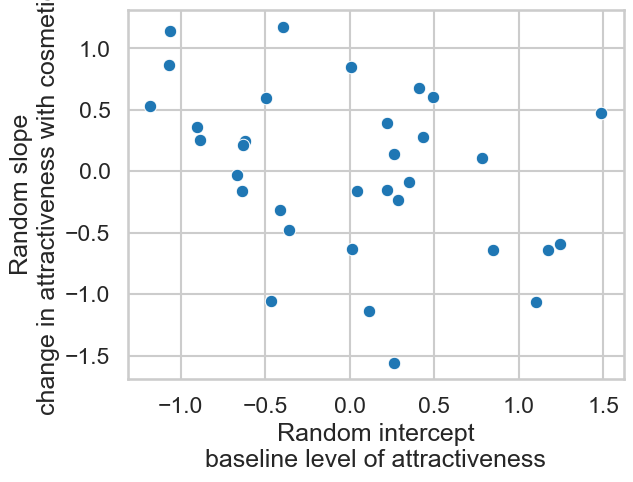

In [26]:
# Correlate
import pingouin as pg
display(pg.corr(slopes.values[:, 0], intercepts.values[:, 0]))

ax = sns.scatterplot(x=intercepts.values[:, 0], y=slopes.values[:, 0])
ax.set(xlabel='Random intercept\nbaseline level of attractiveness',
       ylabel='Random slope\nchange in attractiveness with cosmetics')

This does answer the question our industry partners had - it appears those with greater attractiveness baselines benefit less from cosmetics.

### Variance components - is beauty in the eye of the beholder, or a property of faces?
One clever property of linear mixed models is their ability to figure out how much variance in data comes from various sources. In the previous example we saw that the variation in the ratings of attractiveness with and without cosmetics could be allocated across participants, models, and changes in attractiveness with cosmetics for each model.

As a general rule, if a dataset has repeated measures in a group - whether its participants giving multiple ratings, or faces receiving multiple ratings, then we can use a linear mixed model to tell us how much variability in our dependent variable comes from those sources. These 'intercept only' models are very useful, allowing us greater insight into what's going on in our datasets.

One question psychologists have been interested in for a long time is whether facial attractiveness is in the eye of the beholder, or whether it is a stable feature of faces. Traditional statistical approaches don't really work to answer this question, but a mixed model allows us to figure out the variation we can attribute to people and to faces. Lets see how we do this.

We'll borrow a dataset called the [London Face Database](https://figshare.com/articles/dataset/Face_Research_Lab_London_Set/5047666?file=8542045), an open dataset that contains attractiveness ratings of 102 faces made by 2,513 participants. This should allow us to answer our question. Lets get the data - unfortunately things are a bit slow on such a massive dataset!

In [27]:
# Read in data from link
faces = pd.read_csv('https://figshare.com/ndownloader/files/8542045')
faces.head()

,rater_sex,rater_sexpref,rater_age,X001,X002,X003,X004,X005,X006,X007,...,X137,X138,X139,X140,X141,X142,X143,X144,X172,X173
0,female,either,17.0,3,3,3,3,2,3,5,...,2,3,2,2,2,2,3,5,2,3
1,female,either,17.0,5,2,3,2,1,5,6,...,3,2,3,1,2,1,1,2,1,1
2,female,either,17.1,5,3,4,3,3,4,4,...,5,3,6,1,3,6,3,6,2,6
3,female,either,17.1,4,6,5,5,3,4,5,...,5,4,4,3,5,2,2,4,2,3
4,female,either,17.2,3,4,3,1,1,1,3,...,1,3,5,1,1,1,1,3,1,2


This will need reshaping to the 'long' format. Each row is a rater, and the columns starting with 'X' are the faces. We'll need to:
- Insert a column tracking the rows, which will be our participant ID
- Melt the data into a long format

This is done like so:

In [28]:
# Insert a column tracking rows
faces['pid'] = range(len(faces))

# Melt the data, keeping pid, rater_sex, rater_sexpref, and rater_age as identifying variables
faces_long = faces.melt(id_vars=['pid', 'rater_sex', 'rater_sexpref', 'rater_age'],
                        var_name='face',  value_name='rating')

# Display
display(faces_long)

,pid,rater_sex,rater_sexpref,rater_age,face,rating
0,0,female,either,17.0,X001,3
1,1,female,either,17.0,X001,5
2,2,female,either,17.1,X001,5
3,3,female,either,17.1,X001,4
4,4,female,either,17.2,X001,3
...,...,...,...,...,...,...
256321,2508,male,NaN,61.8,X173,3
256322,2509,male,NaN,88.1,X173,3
256323,2510,NaN,men,17.2,X173,1
256324,2511,NaN,women,19.5,X173,3


This dataset can now be subjected to a variance partitioning approach. First we add a grouping variable which is the same for everyone, then create our variance components, one for pid and one for face.

In [29]:
# Add grouping
faces_long['grouping'] = 1

# Variance components for faces and pid
vc = {'faces': '0 + C(face)', 
      'pids': '0 + C(pid)'}

# Fit a model with just an intercept, note this is done by ~ 1
intercept_only_model = smf.mixedlm('rating ~ 1',
                                   groups='grouping',
                                   vc_formula=vc,
                                   use_sparse=True,
                                   data=faces_long).fit()

# Summary
intercept_only_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM  Dependent Variable: rating      
No. Observations: 256326   Method:             REML        
No. Groups:       1        Scale:              1.1834      
Min. group size:  256326   Log-Likelihood:     -390834.4643
Max. group size:  256326   Converged:          Yes         
Mean group size:  256326.0                                 
------------------------------------------------------------
              Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     3.019     0.078  38.737  0.000   2.866   3.172
faces Var     0.590     0.076                               
pids Var      0.706     0.019                               
===========================================================

"""

From this, we can compute the proportion each source contributes to the total. First, add up the random effect variances and the error variability (the 'scale').

In [30]:
# Total variance
total = intercept_only_model.vcomp.sum() + intercept_only_model.scale

# Then divide the vcomps by the total
vcomps = intercept_only_model.vcomp / total
vcomps

array([0.23803889, 0.28481472])

This suggests faces contribute about 24%, and participants - the eye of the beholder - contributes 28%!

### Predictions with mixed models
We can rely on `marginaleffects` to make predictions from models in the usual way. There is however a philosophical wrinkle when you make predictions with mixed models. Namely, what *kind* of prediction do you want?

A mixed model can make predictions using only the global coefficient estimates (in the summary tables). These are properly the things we want - given we know X, what is Y on average? But these ignore the sources of variability in the data. For example, a mixed model can make specific predictions about an individual participant better than a GLM can, because it knows the random effect of the participant. 

Most of the time, predictions are focused only on the former, global effects. This is what `marginaleffects` will use when making predictions, and will ignore the random effects:

In [31]:
# Compute the difference in makeup
me.predictions(cosmetics_model, newdata=me.datagrid(cosmetics_code=[1, 0]), hypothesis='b1=b2')

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b1=b2""",1.161886,0.132362,8.778118,0.0,inf,0.902462,1.42131
